In [685]:
import matplotlib
import bettermoments as bm
import numpy as np

from multiprocessing import Pool
import matplotlib.pyplot as plt
from eddy.rotationmap import rotationmap
from matplotlib.backends.backend_pdf import PdfPages
import corner
import pandas as pd
from tqdm import tqdm

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import Angle
from disk_dictionary2 import disk_dict
from disk_dictionary2 import get_dict
import os

from pypdf import PdfMerger
import skimage 
from fpdf import FPDF
from astropy.wcs import WCS
from matplotlib.patches import Ellipse
#https://bulk.cv.nrao.edu/deco/users/cjlaw/IMAGING/
%matplotlib inline
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable
import pdfkit
import emcee
import pathlib
import PIL
import jinja2
from gofish import imagecube
import matplotlib.colors as mcolors

In [1913]:
def process_data(infile, data, velax, m_values,  sigma_clip,collapse):
    ''' 
    Pass in data file produced by bettermoments. Apply a channel mask and sigma-clip, and collapse into moments.
    '''

    rms = bm.estimate_RMS(data=data, N=5)

    # define mask based on channels with disk signature
    m = np.zeros(data.shape[0])
    if m_values[0] == 'full':
        m1,m2,m3,m4 = 0, len(m), 0, len(m)
    else:
        m1,m2,m3,m4 = m_values
    
    m[m1:m2] = 1
    m[m3:m4] = 1

    channel_mask = bm.get_channel_mask(data=data, user_mask=m)

    # sigma clip
    threshold_mask = bm.get_threshold_mask(data=data, clip=sigma_clip)

    # combine masks
    data_masked = data * channel_mask * threshold_mask

    # collapse into moments
    if collapse == 'quadratic':
        moments = bm.collapse_quadratic(velax, data_masked, rms)
        v0, dv0, Fnu, dFnu = moments

        # make sure background is set to nan
        bad_indices =  v0<=np.median(v0) 
        v0[bad_indices] = np.nan
        dv0[bad_indices] = np.nan
        Fnu[bad_indices] = np.nan
        dFnu[bad_indices] = np.nan

        # grab min and max v0 for plotting later
        min_v0, max_v0 = np.min(v0), np.max(v0)

        # save moments to fits file
        bm.save_to_FITS(moments =(v0, dv0, Fnu, dFnu), method='quadratic', path=infile)
    
    if collapse == 'zeroth':
        min_v0, max_v0 = None, None
        moments = bm.collapse_zeroth(velax, data_masked, rms)
        # save moments to fits file
        bm.save_to_FITS(moments =moments, method='zeroth', path=infile)

    return min_v0, max_v0, moments, data.shape

def create_postage_stamps(infile):
    '''Plot postage stamps of the channels in the data cube file.'''

    data, velax = bm.load_cube(infile)

    name = infile.split('/')[-1].split('_')[0] if infile.split('/')[-1].split('_')[1] != 'Tau' else '_'.join(infile.split('/')[-1].split('_')[:2])
    emission_line = infile.split('/')[-1].split('_')[1]

    
    data_size = int(np.round(len(data[0])/2))

    # define fov of each postage stamp
    fov = 100

    nrows = 4
    ncols = 5
    f, axes = plt.subplots(nrows, ncols, figsize= (15,15))
    channel_vals = np.arange(10,len(data),10)

    # record highest and lowest values to normalize each postage stamp to same scale
    max_imdata = 0 
    min_imdata = 0
    for nrow in tqdm(range(nrows)):
        for ncol in range(ncols):
            ax = axes[nrow][ncol]
            try:
                channel = channel_vals[5*nrow+ncol]
                imdata = data[channel][data_size-fov:data_size+fov, data_size-fov:data_size+fov]
                if np.nanmax(imdata) > max_imdata:
                    max_imdata = np.max(imdata)
                if np.nanmin(imdata) < min_imdata:
                    print(np.min(imdata))
                    min_imdata = np.min(imdata)
            except:
                pass

    # plot each postage stamp
    for nrow in tqdm(range(nrows)):
        for ncol in range(ncols):
            ax = axes[nrow][ncol]
            try:
                channel = channel_vals[5*nrow+ncol]
                imdata = data[channel][data_size-fov:data_size+fov, data_size-fov:data_size+fov]
                im = ax.imshow(imdata, vmin = min_imdata, vmax=max_imdata, origin='lower', norm='asinh')
                ax.set_title(f'Channel: {channel}', fontsize=15)
            except:
                pass

        
    plt.suptitle(f'{name}, {emission_line}')
    plt.show()

    return f, data, velax, max_imdata, min_imdata

def create_velocity_map(infile, m_values, beam, v_scaling, contours, clevels, mask, over_offsets, centered): 
    '''Plot Rotation Map of the disk'''

    m1, m2,m3,m4 = m_values

    name = infile.split('/')[-1].split('_')[0] if infile.split('/')[-1].split('_')[1] != 'Tau' else '_'.join(infile.split('/')[-1].split('_')[:2])
    region = infile.split('/')[6]

    hdul = fits.open(infile)  # open as FITS file
    hdr = hdul[0].header  # the primary HDU header

    # record the center RA and DEC of the emission line pointing
    dec = hdr['CRVAL2'] 
    ra = hdr['CRVAL1'] 

    # take the disk position from the dictionary
    center_ra = disk_dict[region][name]['RA']
    center_dec = disk_dict[region][name]['Dec']
    print('center',center_ra, center_dec)
    print(Angle(center_ra * u.degree).hms,Angle(center_dec * u.degree).dms)
    
    # subtract the RA of obs pointing from the RA of disk in dictionary, change from degrees --> arcseconds, and correct by cos(dec)
    ra_diff_arcsecond_uncorrected = (center_ra - ra) *3600 
    ra_diff_arcsecond = ra_diff_arcsecond_uncorrected * np.cos(dec * np.pi/180) # RA offset center of the disk
    dec_diff_arcsecond_uncorrected = (center_dec - dec) * 3600 # DEC offset center of the disk
    dec_diff_arcsecond =dec_diff_arcsecond_uncorrected

    if centered:
        ra_diff_arcsecond = over_offsets[0]
        dec_diff_arcsecond = over_offsets[1]


    ## load the velocity files into eddy

    if centered:
        print('taking centered')
        cube = rotationmap(path=f'{infile[:-5]}_v0_masked.fits',
                        uncertainty=f'{infile[:-5]}_dv0_masked.fits',
                        FOV=beam)
    else:
        cube = rotationmap(path=f'{infile[:-5]}_v0.fits',
                            uncertainty=f'{infile[:-5]}_dv0.fits',
                            FOV=beam)

    # plot figure
    rot_fig = cube.plot_data(vmin=v_scaling[0], vmax=v_scaling[1], return_fig=True)
    rot_axes_list = rot_fig.axes

    if m3 != m1:
        rot_axes_list[0].set_title('Channels: '+f'{m1}-{m2},{m3}-{m4}')
    else:
        rot_axes_list[0].set_title('Channels: '+f'{m1}-{m2}')

    # plot center of the disk
    rot_axes_list[0].scatter(ra_diff_arcsecond, dec_diff_arcsecond, color='black',s=20)
    # rot_axes_list[0].scatter(ra, dec, color='green',s=20)

    # over_offsets allow user to manually over disk position, if the dictionary value seems far off 
    if over_offsets != None and centered == False:
        rot_axes_list[0].scatter(over_offsets[0], over_offsets[1], color='white',s=50, marker='x')

    # iterate through and plot each contour
    for wcscont_num in range(len(contours)): 
        wcscont = contours[wcscont_num]
        if wcscont_num == 0:
            # contours are recorded as (RA, DEC). For each contour, subtract the center RA pointing and correct by declination
            rot_axes_list[0].plot((np.array([x[1] for x in wcscont])-ra)*3600 - (ra_diff_arcsecond_uncorrected-ra_diff_arcsecond),(np.array([x[0] for x in wcscont])-dec)*3600 - (dec_diff_arcsecond_uncorrected - dec_diff_arcsecond),color='black',label=f'Continuum Contour',ls='--')
        else:
            rot_axes_list[0].plot((np.array([x[1] for x in wcscont])-ra)*3600 - (ra_diff_arcsecond_uncorrected-ra_diff_arcsecond),(np.array([x[0] for x in wcscont])-dec)*3600 - (dec_diff_arcsecond_uncorrected - dec_diff_arcsecond),color='black',ls='--')

    rot_fig.suptitle(name) 

    # plot a mask if user defined one.
    if mask != None and centered == False:
        if len(mask) == 3:
            ellipse = Ellipse((ra_diff_arcsecond,dec_diff_arcsecond), width=2*mask[0], height=2*mask[1], angle=mask[2], edgecolor='black', ls='dotted',facecolor='none',label='mask')
        else:
            ellipse = Ellipse((mask[3],mask[4]), width=2*mask[0], height=2*mask[1], angle=mask[2], edgecolor='black', ls='dotted',facecolor='none',label='mask')
        plt.gca().add_patch(ellipse)


    plt.legend(loc='upper right')

    return cube, rot_fig, (ra_diff_arcsecond,dec_diff_arcsecond), v_scaling


def remove_background(moments, infile, background_v, dir, mask, beam, v_scaling, offsets, data_shape, force_center):
    '''Remove a large velocity field in the background if cloud is centered on it. Also apply any sort of mask or recentering of data.'''


    force_center_string = ''

    v0, dv0, Fnu, dFnu = moments

    # remove background less than a certain value
    if background_v != None:
        print('erasing background')
        if dir < 0:
            background_indices = v0 <= background_v*1000
        if dir > 0:
            background_indices = v0 >= background_v*1000

        v0[background_indices] = np.nan
        dv0[background_indices] = np.nan
        Fnu[background_indices] = np.nan
        dFnu[background_indices] = np.nan

    bm.save_to_FITS(moments =(v0, dv0, Fnu, dFnu), method='quadratic', path=infile)

    masked_cube = rotationmap(path=f'{infile[:-5]}_v0.fits',
                uncertainty=f'{infile[:-5]}_dv0.fits',
                FOV=beam)

    if mask != None or force_center == True:


        for vfile in [f'{infile[:-5]}_v0.fits', f'{infile[:-5]}_dv0.fits']:
            hdul = fits.open(vfile)
            image_data = hdul[0].data  # Assuming the image data is in the primary HDU

            masked_image_data = image_data
            if mask != None:
                # apply a mask to the data based on user defined input
                ellipse_mask = create_ellipse_array(mask[0], mask[1], mask[2], [offsets[0],offsets[1]], infile, data_shape)
                if len(mask) > 3:
                        ellipse_mask = create_ellipse_array(mask[0], mask[1], mask[2], [mask[3],mask[4]], infile, data_shape)

                image_data = np.flipud(image_data)

                masked_image_data = image_data * ellipse_mask
                bad_indices =  masked_image_data == 0
                masked_image_data[bad_indices] = np.nan

                masked_image_data = np.flipud(masked_image_data)
            
            if force_center == True:
                # recenter the data to center of rotation map. Eddy doesn't have an easy way to do this (that I know), and the MCMC often fails if the disk is too far off center. 
                # this will manually shift the disk by a certain amount in the array. 
                force_center_string = 'Force Recentered'

                dec_scale = np.abs(hdul[0].header['CDELT2'])
                ra_scale = -np.abs(hdul[0].header['CDELT1'])

                ra_offsets_pixel = offsets[0] / (ra_scale * 3600)
                dec_offsets_pixel = offsets[1] / (dec_scale * 3600)

                print('rounded offset', (ra_offsets_pixel,dec_offsets_pixel))

                ra_offsets_pixel = int(np.round(ra_offsets_pixel))
                dec_offsets_pixel = int(np.round(dec_offsets_pixel))
    
                print('rounded offset', (ra_offsets_pixel,dec_offsets_pixel))

                disk_positions = np.argwhere(masked_image_data != np.nan)

                new_array = np.zeros_like(masked_image_data)
                new_array[new_array == 0] = np.nan

                for pos in tqdm(disk_positions):
                    value = masked_image_data[tuple(pos)]
                    new_pos = pos - np.array([dec_offsets_pixel,ra_offsets_pixel])
                    try:
                        new_array[tuple(new_pos)] = value
                    except Exception as e:
                        # print(e)
                        pass

                masked_image_data = new_array


                remaining_offset_ra = (offsets[0] / (ra_scale * 3600) - ra_offsets_pixel) * ra_scale * 3600
                remaining_offset_dec = (offsets[1] / (dec_scale * 3600) - dec_offsets_pixel) * dec_scale * 3600


            hdul[0].data = masked_image_data

            hdul.writeto(f'{vfile[:-5]}_masked.fits', overwrite=True)
            hdul.close()


        masked_cube = rotationmap(path=f'{infile[:-5]}_v0_masked.fits',
                    uncertainty=f'{infile[:-5]}_dv0_masked.fits',
                    FOV=beam)

    # plot the new, masked, edited data.
    # masked_no_bkg_rot_fig = masked_cube.plot_data(vmin=v_scaling[0], vmax=v_scaling[1], return_fig=True)

    # name = infile.split('/')[-1].split('_')[0] if infile.split('/')[-1].split('_')[1] != 'Tau' else '_'.join(infile.split('/')[-1].split('_')[:2])

    # masked_no_bkg_rot_fig.axes[0].set_title(f'Masked Data, with Background Subtraction [km/s] = {background_v}\n {force_center_string}',fontsize=10)
    # plt.suptitle(f'{name}\n')

    return masked_cube, (remaining_offset_ra, remaining_offset_dec)


def run_eddy_mcmc(infile, cube, offsets, annulus, PA_guess, vlsr_guess, nwalkers, nburn, nsims, over_offsets, force_recenter, move_stretch=2, scatter=1e-3):
    '''Run the MCMC that fits a Keplerian rotation pattern to the data.'''

    name = infile.split('/')[-1].split('_')[0] if infile.split('/')[-1].split('_')[1] != 'Tau' else '_'.join(infile.split('/')[-1].split('_')[:2])
    region = infile.split('/')[6]


    # Dictionary to contain the disk parameters.
    mass_prior =  disk_dict[region][name]['M_star']
    distance =   disk_dict[region][name]['distance']
    lit_inc =   disk_dict[region][name]['inclination']

    print(f'SET -- x_offset: {offsets[0]}, y_offset: {offsets[1]}, mass: {mass_prior}, distance: {distance}, inc: {lit_inc}')


    params = {}

    # Start with the free variables in p0.
    params['PA'] = 0

    # if there is an inc recorded in dictionary, fix it and fit for mass
    if lit_inc != '--' and lit_inc != 0:
        print('fixing inclination')
        params['vlsr'] = 1
        params['mstar'] = 2
        params['inc'] = float(lit_inc) # degrees
        p0 = [PA_guess,vlsr_guess*1000, mass_prior, ]
    # if there is no inc recorded in dictionary, fix mass and fit for inc
    else:
        print('fixing mass')
        params['vlsr'] = 1
        params['inc'] = 2
        params['mstar'] = mass_prior
        p0 = [PA_guess, vlsr_guess*1000, 20]

    # set the offsets in x and y equal to the difference between dictionary (RA, DEC) and (RA, DEC) of obs pointing (with cos(dec) correction on RA difference).
    params['x0'] = offsets[0]
    params['y0'] = offsets[1]

    # if the disk had to be recentered manually to center of fov, then the xoff and yoff are slightly different. 
    # Calculate new offsets (accounting for fact that the recentering was off by a few fractions of a pixel) 
    if force_recenter != False:
            
        hdul = fits.open(infile)  # open as FITS file
        hdr = hdul[0].header  # the primary HDU header

        dec_scale = np.abs(hdul[0].header['CDELT2'])
        ra_scale = -np.abs(hdul[0].header['CDELT1'])


        print('og offsets', offsets)
        print('recenter corrections', int(np.round(offsets[0] / (ra_scale * 3600))), int(np.round(offsets[1] / (dec_scale * 3600))))
        print('recenter corrections',(offsets[0] / (ra_scale * 3600)),(offsets[1] / (dec_scale * 3600)))
        print('scale',(np.abs(dec_scale)*3600))

        new_x_offset = ((offsets[0] / (ra_scale * 3600)) - int(np.round(offsets[0] / (ra_scale * 3600)))) * (np.abs(ra_scale)*3600)
        new_y_offset = ((offsets[1] / (dec_scale * 3600)) - int(np.round(offsets[1] / (dec_scale * 3600)))) * (np.abs(dec_scale)*3600)

        params['x0'] = new_x_offset
        params['y0'] = new_y_offset

    # can also simply override with new center position
    if over_offsets != None:

        params['x0'] = float(over_offsets[0])
        params['y0'] = float(over_offsets[1])


    params['dist'] = distance   # parsec

    # apply an annulus mask if desired
    if annulus[0] != None:
        params['r_min'] = float(annulus[0]) if annulus[0] != None else None
        params['r_max'] = float(annulus[1]) if annulus[1] != None else None

    # can change move stretch or move style if MCMC not converging
    if move_stretch > 0:
        moves = emcee.moves.StretchMove(a=move_stretch)
    else:
        print("Using Differential Evolution Move")
        moves = emcee.moves.DEMove()

    print('params',params)

    # fit map, store samples and residual fig with mask
    samples, resid_fig = cube.fit_map(p0=p0, params=params,
                        nwalkers=nwalkers, nburnin=nburn, nsteps=nsims, scatter=scatter, mcmc_kwargs = {'moves':moves})

    model = cube.evaluate_models(samples=samples, params=params)

    # store vlsr and v_std for plotting purposes
    v_std = np.std(model)/1000
    vlsr_output = np.round(np.median([x[1] for x in samples])/1000,2)
    min_val, max_val = vlsr_output - 4*v_std, vlsr_output + 4*v_std, 

    return samples, params, resid_fig, (min_val, max_val)

def plot_model_and_resids(infile, samples, params, offsets, v_scaling, rot_fig, masked_no_bkg_rot_fig, resid_fig, disk_row, postage_stamp_fig, cont_fig):

    '''Plot rotation map, model disk, and residuals, alongside channel maps and dictionary information all in one pdf'''

    name = infile.split('/')[-1].split('_')[0] if infile.split('/')[-1].split('_')[1] != 'Tau' else '_'.join(infile.split('/')[-1].split('_')[:2])
    region = infile.split('/')[6]
    line = infile.split('/')[-1].split('_')[1]

    # get PA output and error from MCMC
    PA = np.median([x[0] for x in samples])
    PA_err_plus, PA_err_minus = np.percentile([x[0] for x in samples],84), np.percentile([x[0] for x in samples],16)

    # plot PA on top of model and rotation figs
    model = cube.evaluate_models(samples=samples, params=params)
    model_fig = cube.plot_model(model=model, return_fig = True, imshow_kwargs = {'vmin': v_scaling[0], 'vmax': v_scaling[1]})
    axes_list = model_fig.axes

    PA_slope = np.tan((PA+90)*np.pi / 180)
    PA_slope_plus = np.tan((PA_err_plus+90)*np.pi / 180)
    PA_slope_minus = np.tan((PA_err_minus+90)*np.pi / 180)


    x= np.arange(-5,5,.1)
    PA_line = -x * PA_slope
    PA_line_plus = -x * PA_slope_plus
    PA_line_min = -x * PA_slope_minus

    ra_diff_arcsecond, dec_diff_arcsecond = params['x0'], params['y0']

    axes_list[0].plot(x+ra_diff_arcsecond,PA_line_plus+dec_diff_arcsecond,color='black',ls='-',linewidth=1)
    axes_list[0].plot(x+ra_diff_arcsecond,PA_line_min+dec_diff_arcsecond,color='black',ls='-',linewidth=1)
    axes_list[0].set_title(f"PA: {np.round(PA,1)}$^\degree$", fontsize=13)
    axes_list[0].scatter(ra_diff_arcsecond,dec_diff_arcsecond,s=50,color='black')


    # plot PA on rotation fig as well
    rot_fig.axes[0].plot(x+offsets[0],PA_line_plus+offsets[1],color='black',linewidth=1)
    rot_fig.axes[0].plot(x+offsets[0],PA_line_min+offsets[1],color='black',linewidth=1)

    # plot PA on masked, no background fig as well (sometimes the same as the rotation fig)
    masked_no_bkg_rot_fig.axes[0].plot(x+ra_diff_arcsecond,PA_line_plus+dec_diff_arcsecond,color='black',linewidth=1)
    masked_no_bkg_rot_fig.axes[0].plot(x+ra_diff_arcsecond,PA_line_min+dec_diff_arcsecond,color='black',linewidth=1)
    masked_no_bkg_rot_fig.axes[0].scatter(ra_diff_arcsecond,dec_diff_arcsecond,s=50,color='black')

    # plot the MCMC so user can see if it converged
    corner_fig = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], labels=[l for l in list(params.keys())[0:len(samples[0])]], label_kwargs={"fontsize": 15}, show_titles=True, bins= 60)

    # plot all the figs in one pdf
    figs = [rot_fig,model_fig,resid_fig,corner_fig,postage_stamp_fig] # list of figures
    pdf_file_path = f'/Users/calebpainter/Downloads/Deco/code/disk_plots_v/full_diagnostic_{name}_{line}_{nsims}_sim_{nwalkers}_walkers.pdf'
    with PdfPages(pdf_file_path) as pdf:
        for fig in figs:
            pdf.savefig(fig, bbox_inches='tight') 

    # also write the dictionary to a page of the pdf
    with open(f'/Users/calebpainter/Downloads/Deco/code/disk_rows/{name}_{line}.txt','w') as f:  
        for key, value in disk_row.items():  
                f.write('%s:     %s\n' % (key, value))  

    # combine the pdfs and delete old ones  
    pdf = FPDF()   
    pdf.add_page()
    pdf.set_font("Arial", size = 8)
    f = open(f'/Users/calebpainter/Downloads/Deco/code/disk_rows/{name}_{line}.txt', 'r')
    for x in f:
        pdf.cell(200, 10, txt = x, ln = 1, align = 'L')
    pdf.output(f'/Users/calebpainter/Downloads/Deco/code/disk_rows/{name}_{line}.pdf')   

    pdfs = [pdf_file_path,f'/Users/calebpainter/Downloads/Deco/code/disk_rows/{name}_{line}.pdf']

    merger = PdfMerger()

    for pdf in pdfs:
        merger.append(pdf)

    merger.write(f'/Users/calebpainter/Downloads/Deco/code/disk_plots_v/final_diagnostic_plots/full_diagnostic_with_dict_{line}_{region}_{name}_{nsims}_sim_{nwalkers}_walkers.pdf')
    merger.close()

    pathlib.Path.unlink(pdf_file_path)

    return model_fig, resid_fig, rot_fig


def get_cont_file(infile):
    '''Find continuum file associated with a gas observation'''

    name = infile.split('/')[-1].split('_')[0] if infile.split('/')[-1].split('_')[1] != 'Tau' else '_'.join(infile.split('/')[-1].split('_')[:2])
    print('name', name)

    file_dir = '/Users/calebpainter/Downloads/products/new'
    file_dirs = os.listdir(file_dir)
    all_cont_files = []
    for fdir in file_dirs:
        try:
            new_dir = file_dir+'/'+fdir+'/cont_images/'
            region_files = os.listdir(new_dir)
            all_cont_files.append([new_dir + x for x in region_files])
        except Exception as e:
            print(e)
            pass

    disk_cont_file = None

    for sublist in all_cont_files:
        for item in sublist:
            if name in item:
                disk_cont_file = item
    print(disk_cont_file)
    return disk_cont_file

def plot_fits(infile, image_file, fov):
    '''plot the fits files with the contour and center position'''
    

    name = infile.split('/')[-1].split('_')[0] if infile.split('/')[-1].split('_')[1] != 'Tau' else '_'.join(infile.split('/')[-1].split('_')[:2]) 
    region = infile.split('/')[6]

    hdu_list = fits.open(image_file, mode='update')
    print(hdu_list.info())

    header = hdu_list[0].header
    key = 'TIMESYS'
    header[key] = header[key].replace('UTC', 'utc')

    # Save changes and close
    hdu_list.flush()
    hdu_list.close()

    hdu_list = fits.open(image_file)

    # grab image data and squeeze out extra dimensions
    og_image_data = hdu_list[0].data
    og_image_data = og_image_data.squeeze()

    image_data = og_image_data[(int(np.round(len(og_image_data)/2)) - fov):(int(np.round(len(og_image_data)/2))+fov), (int(np.round(len(og_image_data)/2)) - fov):(int(np.round(len(og_image_data)/2))+fov)]
    image_data = image_data / np.nanmax(image_data)
        
    wcs = WCS(hdu_list[0].header)  
    wcs_proj = wcs.slice([0,1])

    # plot image data
    cont_fig, ax = plt.subplots(1,1, figsize=(6,6),subplot_kw={'projection': wcs_proj})
    im = ax.imshow(image_data)

    # ax.set_xlabel("RA", fontsize= 20)
    # ax.set_ylabel("Dec", fontsize=20)

    ax.tick_params(axis='both', which='major', labelsize=12, length=5, width=2)

    dec = header['CRVAL2'] 
    ra = header['CRVAL1'] 
    dec_scale = header['CDELT2'] 
    ra_scale = header['CDELT1'] 
    
    # Dictionary to contain the disk parameters.
    disk_center_ra =  disk_dict[region][name]['RA']
    disk_center_dec =  disk_dict[region][name]['Dec']
    print(disk_center_ra, disk_center_dec)

    # get the center of disk plotted against the center of the observation 
    disk_center_ra -= ra
    disk_center_dec -= dec
    disk_center_ra /= (ra_scale)
    disk_center_dec /= (dec_scale)

    # plot center on continuum file
    ax.scatter(int(np.round(len(image_data)/2))+disk_center_ra,int(np.round(len(image_data)/2))+disk_center_dec,color='black',s=10, marker='x')

    # hold contours here
    skcontours = []
    skcontours_wcs3 = []

    # define contour levels and get each one
    contour_levels = [.1, .3, .50, .90]
    for level in contour_levels: 

        # find contours in pixel_x, pixel_y data
        skcontour = skimage.measure.find_contours(image_data,level =level)
        skcontours.append(skcontour)

        # subrract off the pixel_x and pixel_y corresponding to center of observation
        new_c = skcontour[0] - [int(np.round(len(image_data)/2)),int(np.round(len(image_data)/2))] 

        # multiply pixel by RA and DEC scaling (so it is now in offset in degrees)
        new_c = new_c * [dec_scale, ra_scale]
        
        # add the RA and DEC of continuum observation. Contours are now in a weird format --> declination corrected size, but all in RA, DEC coords. 
        # Probably a nicer way to do this but it works
        new_c = new_c + [dec, ra]

        skcontours_wcs3.append(new_c)

    for skcontour in skcontours:
        try:
            ax.plot([x[1] for x in skcontour[0]],[x[0] for x in skcontour[0]],color='white')
        except:
            print("bad")


    plt.tight_layout()
    plt.savefig('/Users/calebpainter/Downloads/cont.png')

    return skcontours, contour_levels, cont_fig, skcontours_wcs3

def create_ellipse_array(a, b, theta, center, infile, data_shape):

    depth = data_shape[0]
    size= data_shape[1]



    hdul = fits.open(f'{infile[:-5]}_v0.fits')  # open as FITS file
    hdr = hdul[0].header  # the primary HDU header
    dec_scale = hdr['CDELT2'] 
    ra_scale = hdr['CDELT1'] 

    a /= (ra_scale*3600)
    b /= (dec_scale*3600)

    center[0] /= (np.abs(ra_scale)*3600*size/2)
    center[1] /= (np.abs(dec_scale)*3600*size/2)

    print(a,b)
    a /= (size/2)
    b /= (size/2)

    print(a,b)
    theta += 90
    
    # Create a grid of size x size
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)
    
    # Convert angle from degrees to radians
    theta_rad = np.deg2rad(theta)
    
    print('center',center)
    print(a,b)
    
    # Compute the equation of the ellipse
    ellipse_eq = (((X+center[0]) * np.cos(theta_rad) + (Y+center[1]) * np.sin(theta_rad))**2 / b**2 
                  + ((X+center[0]) * np.sin(theta_rad) - (Y+center[1]) * np.cos(theta_rad))**2 / a**2)
    
    # Create mask for points inside the ellipse
    ellipse_mask = ellipse_eq <= 1
    
    return ellipse_mask.astype(int)  # Convert boolean array to integer (0 or 1)

def removekey(d, key):
    r = dict(d)
    del r[key]
    return r

def get_file(region_num, file_num, line, name):
    ''' Get gas file from directory'''
    
    all_files = []

    if line == 'CO':
        dir = ''
    else:
        dir = f'{line}/'

    '''Lupus'''
    region_dir = f'/Users/calebpainter/Downloads/DECO/fits_files/Lupus/{dir}'
    try:
        infiles =  [region_dir+x for x in os.listdir(region_dir) if x[-10:]=='image.fits']
        all_files.append(infiles)
        print('added',region_dir)
    except:
        all_files.append([])
        pass

    '''ROph'''
    region_dir = f'/Users/calebpainter/Downloads/DECO/fits_files/ROph/{dir}'
    try:
        infiles =  [region_dir+x for x in os.listdir(region_dir) if x[-10:]=='image.fits']
        all_files.append(infiles)
        print('added',region_dir)
    except:
        all_files.append([])
        pass

    '''ChamI'''
    region_dir = f'/Users/calebpainter/Downloads/DECO/fits_files/ChamI/{dir}'
    try:
        infiles = [region_dir+x for x in os.listdir(region_dir) if x[-10:]=='image.fits']
        all_files.append(infiles)
        print('added',region_dir)

    except:
        all_files.append([])
        pass

    '''Taurus'''
    region_dir = f'/Users/calebpainter/Downloads/DECO/fits_files/Taurus/{dir}'
    try:
        infiles =  [region_dir+x for x in os.listdir(region_dir) if x[-10:]=='image.fits']
        all_files.append(infiles)
        print('added',region_dir)

    except:
        all_files.append([])
        pass

    print('region dir', region_dir)
    print(f'File Group:\n')
    for n, file in enumerate(all_files[region_num]):
        print(f'{n}: {file}\n')

    infile = all_files[region_num][file_num]
    if name != '':
        for pos_file in all_files[region_num]:
            if name in pos_file:
                infile = pos_file

    print('Disk File: ', infile)
    return infile


In [1963]:
# Define Region Number, File Number, and Emission Line and get the associated file
df = pd.read_csv('DECO_disk_eddy_outputs.csv', index_col=0)
region_num = 1
file_num = 5
line = ''

name = 'J162755.6-242618'

infile = get_file(region_num, file_num, line, name)



name = infile.split('/')[-1].split('_')[0] if infile.split('/')[-1].split('_')[1] != 'Tau' else '_'.join(infile.split('/')[-1].split('_')[:2]) 


added /Users/calebpainter/Downloads/DECO/fits_files/Lupus//
added /Users/calebpainter/Downloads/DECO/fits_files/ROph//
added /Users/calebpainter/Downloads/DECO/fits_files/ChamI//
added /Users/calebpainter/Downloads/DECO/fits_files/Taurus//
region dir /Users/calebpainter/Downloads/DECO/fits_files/Taurus//
File Group:

0: /Users/calebpainter/Downloads/DECO/fits_files/ROph//J162623.6-242439_CO_230.538GHz.image.fits

1: /Users/calebpainter/Downloads/DECO/fits_files/ROph//J162738.3-243658_CO_230.538GHz.image.fits

2: /Users/calebpainter/Downloads/DECO/fits_files/ROph//J162739.0-235818_CO_230.538GHz.image.fits

3: /Users/calebpainter/Downloads/DECO/fits_files/ROph//J162536.7-241542_CO_230.538GHz.image.fits

4: /Users/calebpainter/Downloads/DECO/fits_files/ROph//J162730.2-242743_CO_230.538GHz.image.fits

5: /Users/calebpainter/Downloads/DECO/fits_files/ROph//J162618.9-242820_CO_230.538GHz.image.fits

6: /Users/calebpainter/Downloads/DECO/fits_files/ROph//J162733.1-244115_CO_230.538GHz.image.f

name J162730.2-242743
[Errno 20] Not a directory: '/Users/calebpainter/Downloads/products/new/.DS_Store/cont_images/'
/Users/calebpainter/Downloads/products/new/RhoOph_CCH_setting/cont_images/member.uid___A001_X2d20_X1f1f.J162730.2-242743_sci.spw25_27_29_31_33_35_37_39_41_43.cont.I.pbcor.fits
Filename: /Users/calebpainter/Downloads/products/new/RhoOph_CCH_setting/cont_images/member.uid___A001_X2d20_X1f1f.J162730.2-242743_sci.spw25_27_29_31_33_35_37_39_41_43.cont.I.pbcor.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     419   (768, 768, 1, 1)   float32   
None
246.87570749999998 -24.4622325


100%|██████████| 4/4 [00:00<00:00, 213.45it/s]


-0.030735498
-0.033400342
-0.044907026
-0.07516152


100%|██████████| 4/4 [00:00<00:00, 148.46it/s]


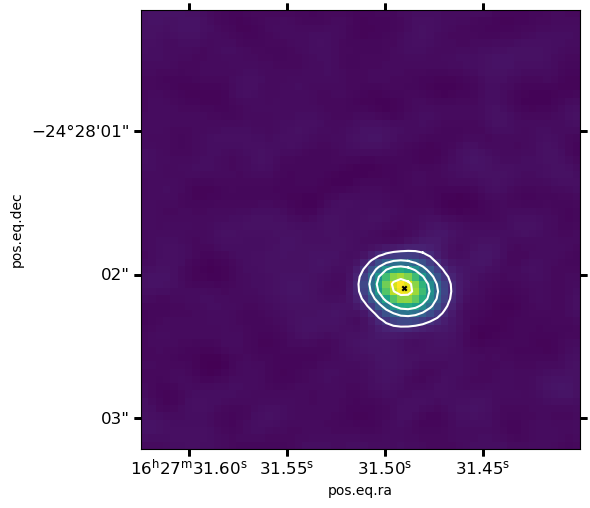

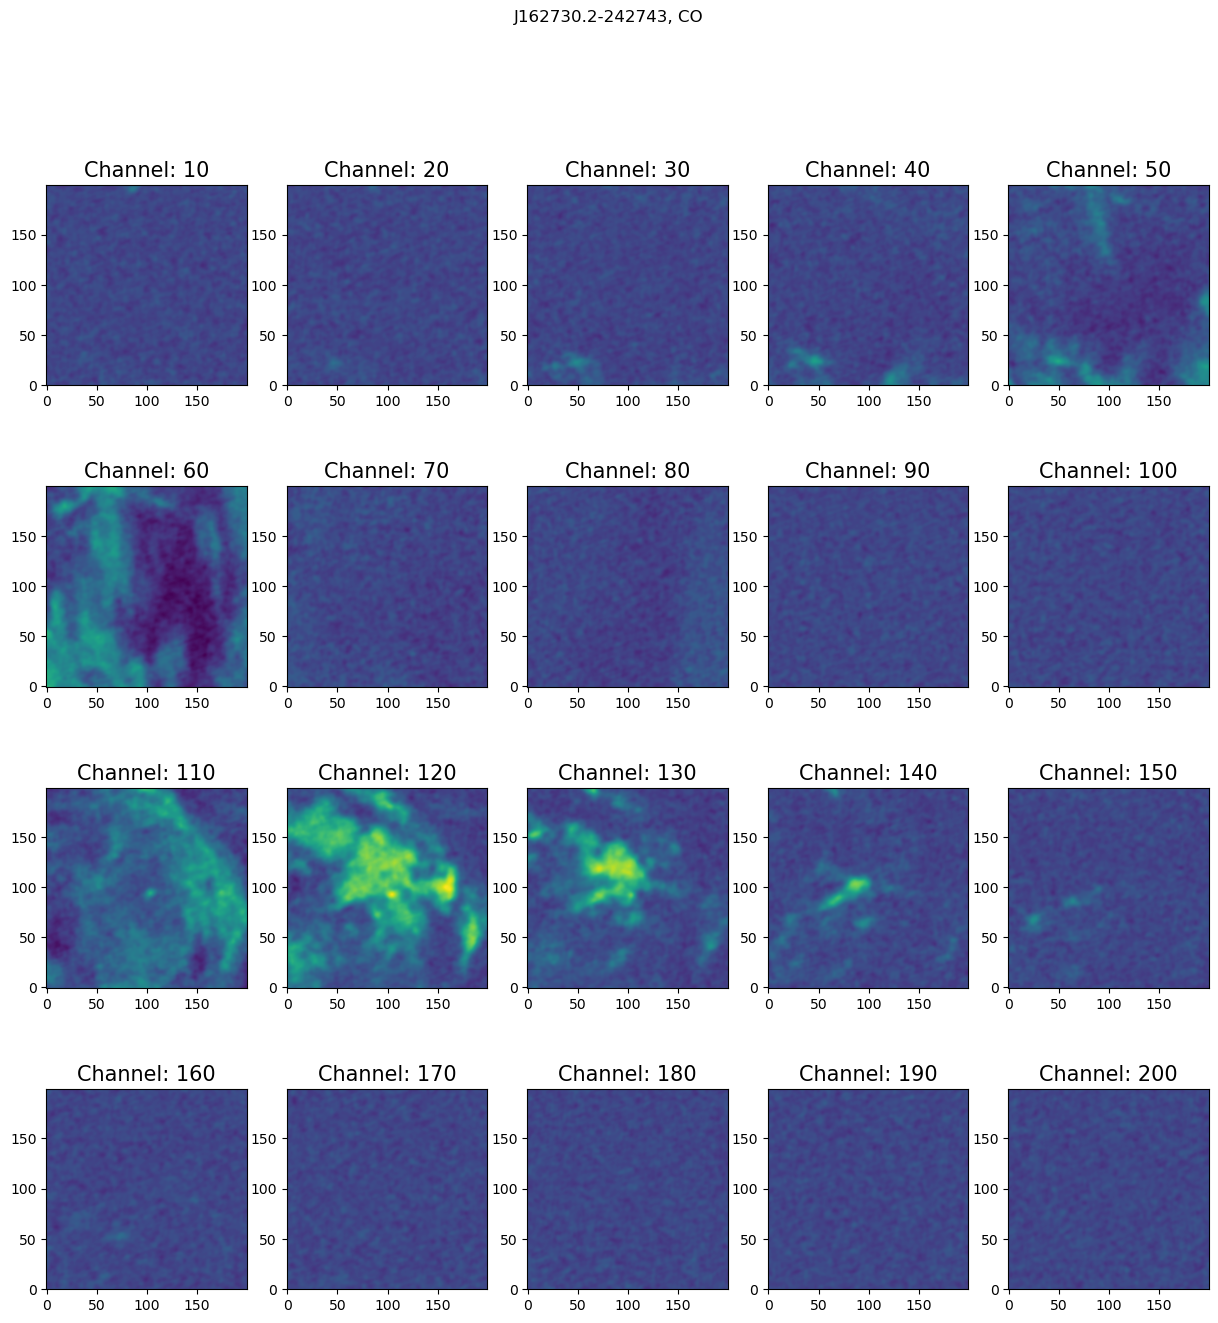

In [1938]:
#Grab corresponding Continuum File

disk_cont_file = get_cont_file(infile)
skcontours, contour_levels, cont_fig, skcontours_wcs3 = plot_fits(infile,disk_cont_file, 30)

postage_stamp_fig, data, velax, maxpostage, minpostage = create_postage_stamps(infile)

In [1946]:
# define channels for mask, get the velocity data
try:
    channels = list(df[df['Name']==name]['Channels'])[0]
    if channels[0] == '(':
        channels = eval(channels)
except:
    print('not in dict')
    channels = (0, 200, 0, 200)
# channels = (0, 85, 95, 150)
print("running on channels", channels)
min_v0, max_v0, moments, data_shape = process_data(infile, data, velax, channels,6, 'quadratic')
v0 = moments[0]

running on channels (70, 110, 140, 200)


center 246.87570749999998 -24.4622325
hms_tuple(h=16.0, m=27.0, s=30.169800000001885) dms_tuple(d=-24.0, m=-27.0, s=-44.03699999999617)
(-0.25018268655097864, -0.4347136799907503)


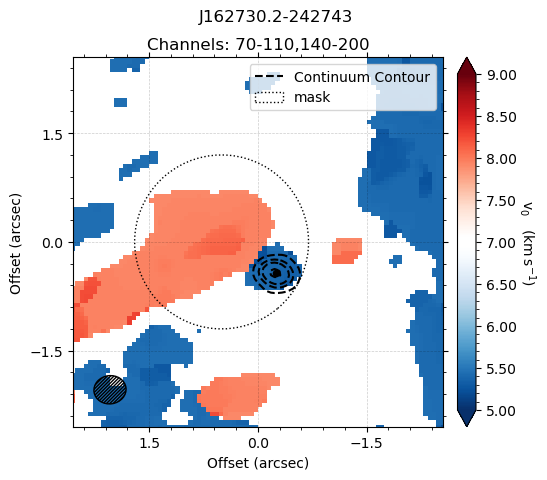

In [1951]:
# plot rotation figure

# definge beam and velocity color bar
beam = 5
v_scaling = (5,9) 

# define a mask if needed
mask = [1.2, 1.2, -40, .5, 0] # semi-major, semi-minor, angle
# mask = None 

# define a background velocity cut if needed
background_v = 6
background_v = None

# override disk position if needed
over_offsets = (.5, -.2)
over_offsets = None

centered = False

cube, rot_fig, offsets, v_scaling = create_velocity_map(infile, channels, beam, v_scaling, skcontours_wcs3, contour_levels, mask, over_offsets, centered)
print(offsets)

-19.999999999996 19.999999999996
-0.04938271604937284 0.04938271604937284
center [-0.01029558380868019, -0.017889451851467626]
-0.04938271604937284 0.04938271604937284
-19.999999999996 19.999999999996
-0.04938271604937284 0.04938271604937284
center [0.020576131687238684, 0.0]
-0.04938271604937284 0.04938271604937284
rounded offset (4.169711442515476, -7.2452279998443885)
rounded offset (4, -7)


100%|██████████| 656100/656100 [00:01<00:00, 556464.40it/s]


-19.999999999996 19.999999999996
-0.04938271604937284 0.04938271604937284
center [-0.01029558380868019, -0.017889451851467626]
-0.04938271604937284 0.04938271604937284
-19.999999999996 19.999999999996
-0.04938271604937284 0.04938271604937284
center [0.020576131687238684, 0.0]
-0.04938271604937284 0.04938271604937284
rounded offset (4.169711442515476, -7.2452279998443885)
rounded offset (4, -7)


100%|██████████| 656100/656100 [00:01<00:00, 606691.63it/s]


center 246.87570749999998 -24.4622325
hms_tuple(h=16.0, m=27.0, s=30.169800000001885) dms_tuple(d=-24.0, m=-27.0, s=-44.03699999999617)
taking centered


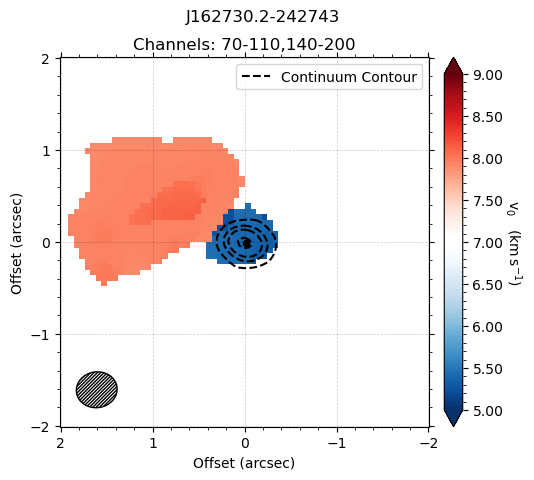

In [1952]:
# remove background if needed, apply masks, or force the data to center of FOV
beam = 4

force_recenter = True

if over_offsets != None:
    masked_cube, (remaining_ra, remaining_dec) = remove_background(moments, infile, background_v, 1,  mask, beam, v_scaling, over_offsets, data_shape, force_recenter)
else:
    masked_cube, (remaining_ra, remaining_dec) = remove_background(moments, infile, background_v,1, mask, beam, v_scaling, offsets, data_shape, force_recenter)

cube, rot_fig, offsets, v_scaling = create_velocity_map(infile, channels, beam, v_scaling, skcontours_wcs3, contour_levels, mask, (remaining_ra, remaining_dec), True)

SET -- x_offset: -0.01018268655093061, y_offset: -0.014713679990666252, mass: 0.5975, distance: 139.0, inc: 87
fixing inclination
og offsets (-0.01018268655093061, -0.014713679990666252)
recenter corrections 0 0
recenter corrections 0.1697114425154762 -0.24522799984438848
scale 0.060000000000012
params {'PA': 0, 'vlsr': 1, 'mstar': 2, 'inc': 87.0, 'x0': 0.01018268655093061, 'y0': -0.014713679990666252, 'dist': 139.0}
Changed File
Assuming:
	p0 = [PA, vlsr, mstar].
Starting positions:
	p0 = ['5.50e+01', '7.00e+03', '5.98e-01']
scatter 0.001
original p0 [5.500e+01 7.000e+03 5.975e-01]
scatter p0 [[5.49728005e+01 7.00321821e+03 5.97505626e-01]
 [5.50370033e+01 7.01261188e+03 5.97356581e-01]
 [5.49960919e+01 6.99646967e+03 5.98437881e-01]
 [5.48982401e+01 7.00729677e+03 5.97677510e-01]
 [5.49599504e+01 7.00270206e+03 5.97853156e-01]
 [5.50221036e+01 6.98798661e+03 5.97798817e-01]
 [5.51206475e+01 6.98860182e+03 5.97793525e-01]
 [5.49884435e+01 7.00336060e+03 5.97498792e-01]
 [5.49908441e+0

100%|██████████| 1300/1300 [00:03<00:00, 355.80it/s]


Acceptance rate: 0.61
center 246.87570749999998 -24.4622325
hms_tuple(h=16.0, m=27.0, s=30.169800000001885) dms_tuple(d=-24.0, m=-27.0, s=-44.03699999999617)
taking centered


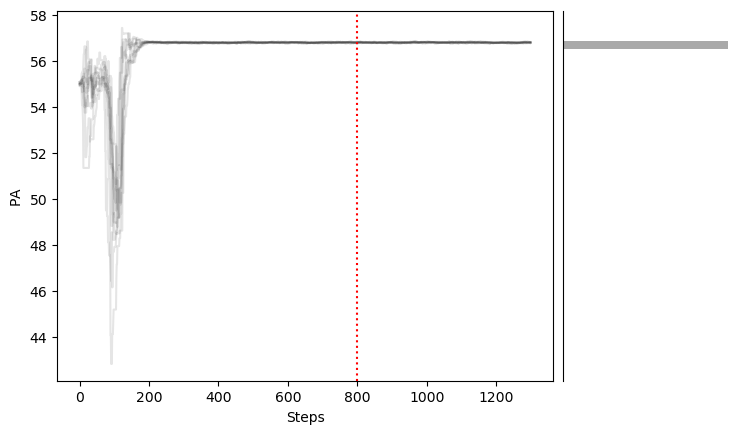

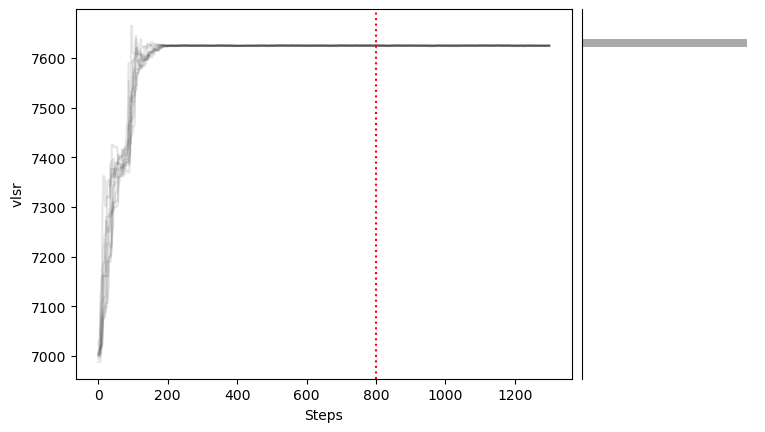

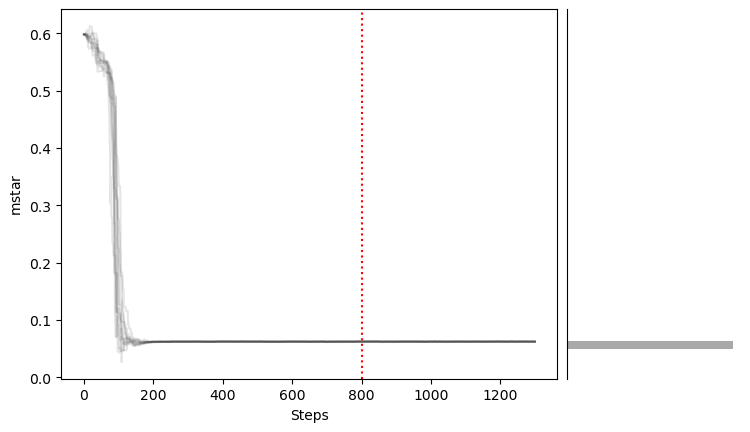

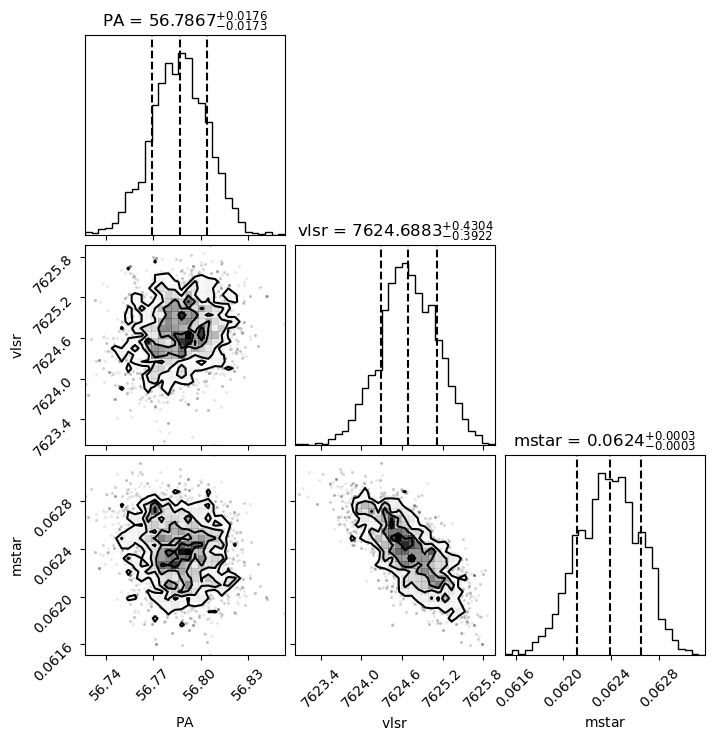

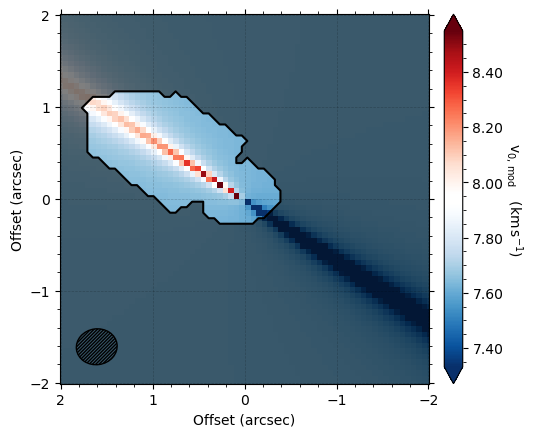

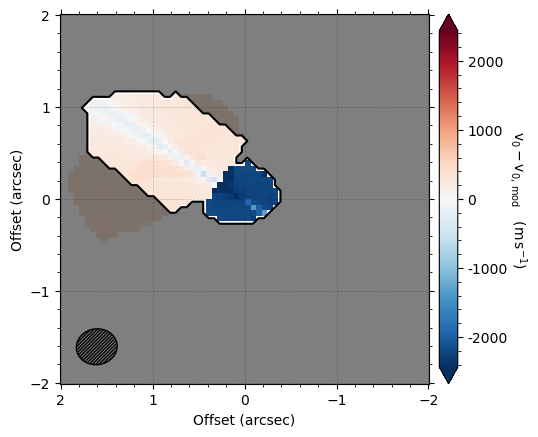

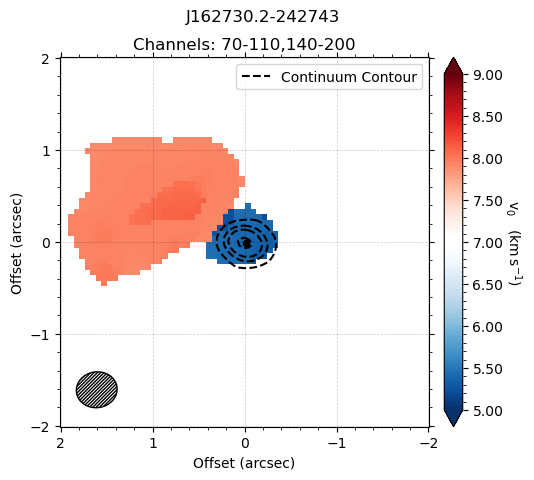

In [1955]:
# Run MCMC

# define MCMC params
nwalkers, nburn, nsims = 10, 800, 500
move_stretch = 2
scatter = 1e-3

# define annulus
rmin, rmax = 1, 4
rmin, rmax = None, None 

# give guess for PA and vlsr
PA_guess = 55
vlsr_guess = 7

# get samples and params, and a better velocity color bar scaling based on model
samples, params, resid_fig, better_v_scaling = run_eddy_mcmc(infile, masked_cube, offsets, (rmin,rmax), PA_guess, vlsr_guess, nwalkers, nburn, nsims,over_offsets,force_recenter, move_stretch, scatter)

# redefine color bar scaling if needed
better_v_scaling = v_scaling

# remake figures with consitent color bars
_, rot_fig, _, _ = create_velocity_map(infile, channels, beam, better_v_scaling, skcontours_wcs3, contour_levels, mask, (remaining_ra, remaining_dec), True)
# masked_no_bkg_rot_fig, _, _ = remove_background(moments, infile, background_v, mask, beam, better_v_scaling, offsets, data_shape,force_recenter)

{'Name': 'J162730.2-242743', 'Region': 'ROph', 'File': '/Users/calebpainter/Downloads/DECO/fits_files/ROph//J162730.2-242743_CO_230.538GHz.image.fits', 'Emmision Line': 'CO', 'Channels': (70, 110, 140, 200), 'X-pos': 246.875707, 'Y-pos': -24.462232, 'X-offset': -0.01, 'Y-offset': -0.01, 'Literature PA': 61.0, 'Eddy PA': 56.79, 'Literature Mass [M]': 0.5975, 'Eddy Mass [M]': 0.06, 'DECO Dict vsys [km/s]': 4.8, 'Eddy vlsr [m/s]': 7.62, 'Literature Inc': 87, 'Eddy Inc': '--', 'Literature Distance [Mpc]': 139.0, 'Eddy rmin, rmax ["]': (None, None), 'Eddy params (nwalkers, nburn, nsteps)': (10, 800, 500), 'Velocity Mask': [1.2, 1.2, -40, 0.5, 0], 'Background Velocity Removal': None, 'Notes': 'MCMC GOOD'}


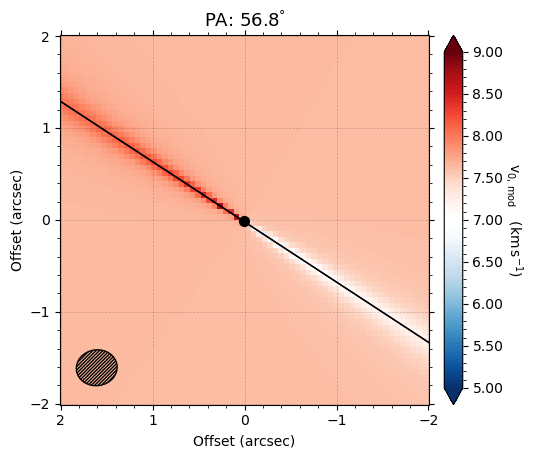

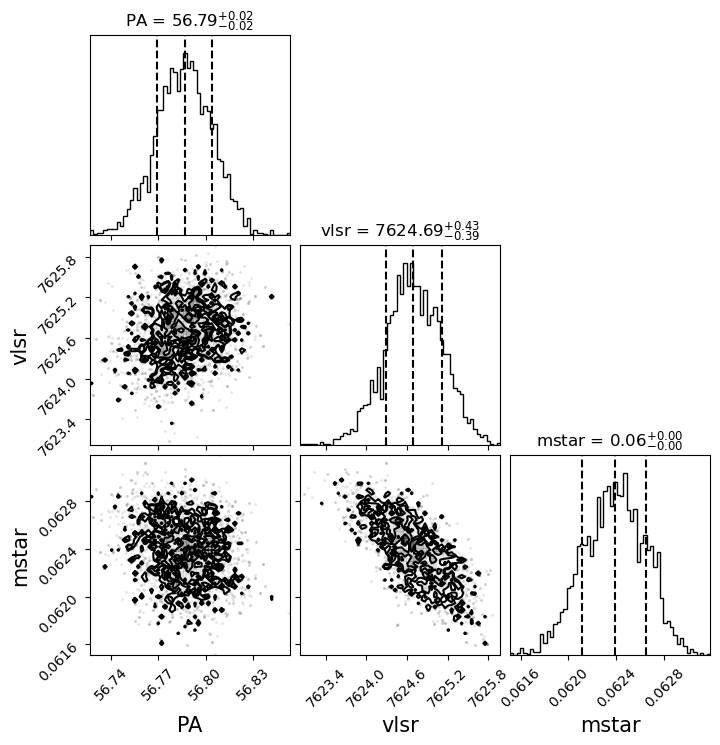

In [1958]:
# Save everything to a dictionary

comment = 'MCMC GOOD'

region = infile.split('/')[6]
name = infile.split('/')[-1].split('_')[0] if infile.split('/')[-1].split('_')[1] != 'Tau' else '_'.join(infile.split('/')[-1].split('_')[:2])

lit_inc = disk_dict[region][name]['inclination']

if lit_inc != '--' and lit_inc != 0:
    eddy_vlsr = np.round(np.median([x[1] for x in samples])/1000,2)
    eddy_mstar = np.round(np.median([x[2] for x in samples]),2)
    eddy_inc ='--'
    lit_inc = np.round(disk_dict[region][name]['inclination'],2)
else:
    eddy_vlsr = np.round(np.median([x[1] for x in samples])/1000,2)
    eddy_mstar = '--'
    eddy_inc = np.round(np.median([x[2] for x in samples]),2)


disk_row = {
    'Name': name,
    'Region': region,
    'File': infile,
    'Emmision Line': infile.split('/')[-1].split('_')[1],
    'Channels': channels,
    'X-pos': np.round(disk_dict[region][name]['RA'],6),
    'Y-pos': np.round(disk_dict[region][name]['Dec'],6), 
    'X-offset': np.round(offsets[0],2),
    'Y-offset': np.round(offsets[1],2),
    'Literature PA': disk_dict[region][name]['PA'],
    'Eddy PA': np.round(np.median([x[0] for x in samples]),2),
    'Literature Mass [M]': disk_dict[region][name]['M_star'],
    'Eddy Mass [M]': eddy_mstar,
    'DECO Dict vsys [km/s]': disk_dict[region][name]['vsys'],
    'Eddy vlsr [m/s]': eddy_vlsr,
    'Literature Inc': lit_inc,
    'Eddy Inc': eddy_inc,
    'Literature Distance [Mpc]': disk_dict[region][name]['distance'],
    'Eddy rmin, rmax ["]': (rmin,rmax),
    'Eddy params (nwalkers, nburn, nsteps)': (nwalkers, nburn, nsims),
    'Velocity Mask': mask,
    'Background Velocity Removal': background_v,
    'Notes': comment,
}

print(disk_row)
df_row = pd.DataFrame([disk_row])
df_row.head()

model_f, resid_f, rot_f = plot_model_and_resids(infile, samples, params, offsets, better_v_scaling, rot_fig, masked_no_bkg_rot_fig, resid_fig, disk_row, postage_stamp_fig, cont_fig)

In [1907]:
# read in master dataframe and save new row to it
df = pd.read_csv('DECO_disk_eddy_outputs.csv', index_col=0)
df

,Name,Region,File,Emmision Line,Channels,X-pos,Y-pos,X-offset,Y-offset,Literature PA,...,Eddy vlsr [m/s],"Eddy rmin, rmax [""]",Literature Distance [Mpc],Literature Inc,Eddy Inc,"Eddy params (nwalkers, nburn, nsteps)",Velocity Mask,Notes,DECO Dict vsys [km/s],Background Velocity Removal
0,Sz68,Lupus,/Users/calebpainter/Downloads/DECO/fits_files/...,CO,"(50, 105, 150, 200)",236.303488,-34.291990,0.000,-0.010,0.288,...,5.42,"(0, 1.5)",158.00,34.01,--,"(10, 800, 500)",NaN,MCMC GOOD,2.60,NaN
1,Sz90,Lupus,/Users/calebpainter/Downloads/DECO/fits_files/...,CO,"(10, 180, 10, 180)",241.791868,-39.184402,-0.030,0.020,8.837,...,5.24,"(0, 1.5)",160.37,52.37,--,"(10, 800, 500)",NaN,MCMC GOOD,5.24,NaN
2,Sz95,Lupus,/Users/calebpainter/Downloads/DECO/fits_files/...,CO,"(0, 200, 0, 200)",241.967867,-38.968504,0.010,0.010,92.463,...,4.68,"(0, 1.5)",160.47,53.13,--,"(10, 800, 500)","[0.3, 0.6, -5]","MCMC GOOD, bad fit because center is off from ...",3.10,NaN
3,Sz96,Lupus,/Users/calebpainter/Downloads/DECO/fits_files/...,CO,"(10, 180, 10, 180)",242.052530,-39.142777,0.146,0.378,91.498,...,1.24,"(0.05, 1.7)",155.97,48.997,--,"(32, 800, 500)",NaN,MCMC GOOD,4.70,NaN
4,J162738.3-243658,ROph,/Users/calebpainter/Downloads/DECO/fits_files/...,CO,"(120, 180, 120, 180)",246.909617,-24.616443,0.020,-0.010,16.1,...,6.32,"(None, None)",139.46,69.58,--,"(10, 800, 500)",NaN,MCMC GOOD,4.20,6.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,J16083070-3828268,Lupus,/Users/calebpainter/Downloads/DECO/fits_files/...,CO,"(0, 200, 0, 200)",242.127825,-38.474291,0.000,-0.010,107.501,...,5.16,"(None, None)",158.00,72.76,--,"(10, 800, 500)","[2.5, 1.4, -20]",MCMC GOOD,5.29,NaN
57,J11094742-7726290,ChamI,/Users/calebpainter/Downloads/DECO/fits_files/...,CO,"(0, 200, 0, 200)",167.446910,-77.441441,-0.020,-0.020,29.37,...,5.17,"(None, None)",191.42,54.12,--,"(10, 800, 500)",NaN,MCMC GOOD,4.90,NaN
58,J11114632-7620092,ChamI,/Users/calebpainter/Downloads/DECO/fits_files/...,CO,"(0, 200, 0, 200)",167.942437,-76.335822,0.020,0.020,136.42,...,4.94,"(None, None)",191.61,56.51,--,"(10, 800, 500)","[1, 2, -70]",MCMC GOOD,5.50,NaN
59,J11104959-7717517,ChamI,/Users/calebpainter/Downloads/DECO/fits_files/...,CO,"(0, 200, 0, 200)",167.705976,-77.297703,-0.010,-0.020,59.76,...,4.57,"(None, None)",186.69,61.71,--,"(10, 800, 500)","[1, 2, -70]",MCMC GOOD,5.30,NaN


In [1908]:
# save new row, overwriting any old ones with same name

if len(df.index[df['Name'] == name].tolist()) > 0:
    if df.iloc[df.index[df['Name'] == name].tolist()[0]][3] == infile.split('/')[-1].split('_')[1]:
        print("resetting")
        df.iloc[df.index[df['Name'] == name].tolist()[0]] = disk_row 
    else:
        df = pd.concat([df, pd.DataFrame([disk_row])], ignore_index=True)
else:
    df = pd.concat([df, pd.DataFrame([disk_row])], ignore_index=True)
df.to_csv('DECO_disk_eddy_outputs.csv')

resetting


In [836]:
latex_df = df.drop(columns=['File', 'X-offset', 'Y-offset', ' DECO Dict vsys [m/s]', 'Eddy rmin, rmax ["]', 'Eddy params (nwalkers, nburn, nsteps)', 'Velocity Mask', 'DECO Dict vsys [km/s]', 'Background Velocity Removal'])

latex_df = latex_df[['Region', 'Name', 'Emmision Line', 'Channels', 'X-pos', 'Y-pos',
       'Literature PA', 'Eddy PA', 'Literature Mass [M]', 'Eddy Mass [M]',
       'Eddy vlsr [m/s]', 'Literature Distance [Mpc]', 'Literature Inc',
       'Eddy Inc', 'Notes']]


latex_table = latex_df.to_latex(float_format="%.2f")
print(latex_table)

\begin{tabular}{lllllrrlrrlrrlll}
\toprule
 & Region & Name & Emmision Line & Channels & X-pos & Y-pos & Literature PA & Eddy PA & Literature Mass [M] & Eddy Mass [M] & Eddy vlsr [m/s] & Literature Distance [Mpc] & Literature Inc & Eddy Inc & Notes \\
\midrule
0 & Lupus & Sz68 & CO & (50, 105, 150, 200) & 236.30 & -34.29 & 0.288 & 165.08 & 1.32 & 2.37 & 4.98 & 158.00 & 34.01 & -- & MCMC GOOD \\
1 & Lupus & Sz90 & CO & (10, 180, 10, 180) & 241.79 & -39.18 & 8.84 & 111.23 & 0.73 & 1.77 & 5.24 & 160.37 & 52.37 & -- & MCMC GOOD \\
2 & Lupus & Sz95 & CO & (0, 200, 0, 200) & 241.97 & -38.97 & 92.463 & 177.30 & 0.29 & 0.01 & 4.68 & 160.47 & 53.13 & -- & MCMC GOOD, bad fit because center is off from blue/red of gas \\
3 & Lupus & Sz96 & CO & (10, 180, 10, 180) & 242.05 & -39.14 & 91.498 & 27.95 & 0.46 & 1.2 & 1.24 & 155.97 & 48.997 & -- & MCMC GOOD \\
4 & ROph & J162738.3-243658 & CO & (120, 180, 120, 180) & 246.91 & -24.62 & 16.1 & 113.43 & 0.65 & 0.01 & 6.31 & 139.46 & 69.58 & -- & MCMC GOOD

In [1962]:
list(set(list(disk_dict['ChamI'].keys()))-set(list(df['Name'])))

['J11100469-7635452', 'J11081509-7733531', 'J10581677-7717170']

## Radial Profiles

In [581]:
infile

'/Users/calebpainter/Downloads/DECO/fits_files/ROph//J162656.8-241351_CO_230.538GHz.image.fits'

In [582]:
min_v0, max_v0, moments, data_shape = process_data(infile, data, velax, channels,4, 'zeroth')

In [531]:
infile[:-5]

'/Users/calebpainter/Downloads/DECO/fits_files/ChamI//J10555973-7724399_CO_230.538GHz.image'

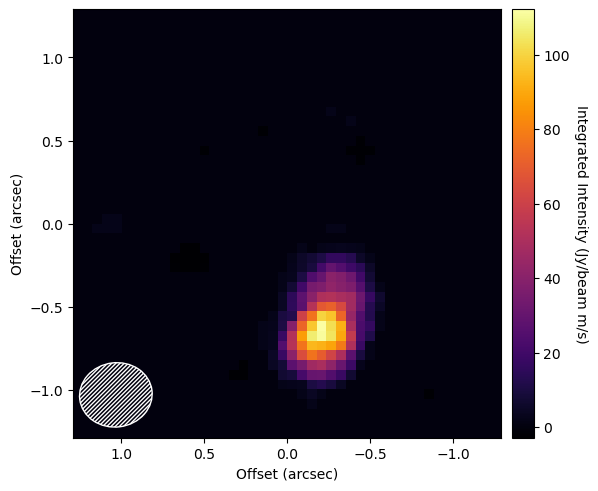

In [585]:
cube = imagecube(f'{infile[:-5]}_M0.fits', FOV=2.5)
fig, ax = plt.subplots(constrained_layout=True)
im = ax.imshow(cube.data, origin='lower', extent=cube.extent, cmap='inferno')
cb = plt.colorbar(im, pad=0.02)
ax.set_xlabel('Offset (arcsec)')
ax.set_ylabel('Offset (arcsec)')
cb.set_label('Integrated Intensity (Jy/beam m/s)', rotation=270, labelpad=13)
cube.plot_beam(ax=ax, color='w')

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


Text(0, 0.5, 'Integrated Intensity (Jy/beam m/s)')

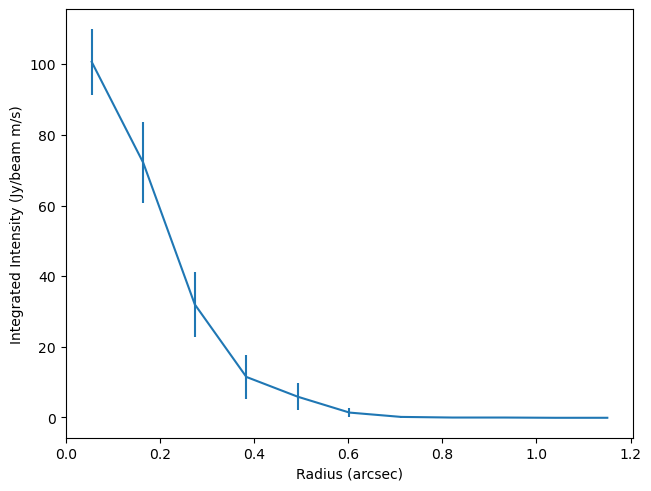

In [589]:
x, y, dy = cube.radial_profile(x0=-.2, y0=-.7,inc=43.74, PA=14.7)
fig, ax = plt.subplots(constrained_layout=True)
ax.errorbar(x, y, dy)
# ax.set_yscale('log')
ax.set_xlabel('Radius (arcsec)')
ax.set_ylabel('Integrated Intensity (Jy/beam m/s)')

## Old messy code

In [341]:
name = infile.split('/')[-1].split('_')[0] if infile.split('/')[-1].split('_')[1] != 'Tau' else '_'.join(infile.split('/')[-1].split('_')[:2])
region = infile.split('/')[-2]
region = 'ChaI'

hdul = fits.open(infile)  # open aa FITS file
hdr = hdul[0].header  # the primary HDU header
dec = hdr['CRVAL2']
ra = hdr['CRVAL1'] 


center_ra = disk_dict['ChaI'][name]['RA']
center_dec = disk_dict['ChaI'][name]['Dec']

ra_diff_arcsecond = (center_ra - ra) * (np.cos(center_dec * np.pi / 180))*3600
dec_diff_arcsecond = (center_dec - dec) * 3600


KeyError: 'ChaI'

In [347]:
hdr['CDELT2'] * 3600

0.039999999999996004

NameError: name 'm1' is not defined

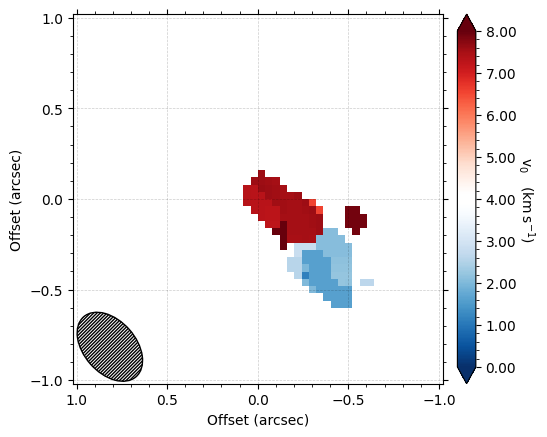

In [10]:
## do Eddy stuff
name = infile.split('/')[-1].split('_')[0] if infile.split('/')[-1].split('_')[1] != 'Tau' else '_'.join(infile.split('/')[-1].split('_')[:2])
cube = rotationmap(path=f'{infile[:-5]}_v0.fits',
                   uncertainty=f'{infile[:-5]}_dv0.fits',
                   FOV=2.0)
rot_fig = cube.plot_data(vmin=0, vmax=8, return_fig=True)
rot_axes_list = rot_fig.axes
rot_axes_list[0].set_title('Channels: '+f'{m1}-{m2},{m3}-{m4}')
rot_fig.suptitle(name)
rot_axes_list[0].scatter(ra_diff_arcsecond, dec_diff_arcsecond, color='black',s=20)

print(name)
# plt.savefig(f'/Users/calebpainter/Downloads/DECO/disk_plots_v/rotation_cube_map_{name}.png')

In [1116]:
# Dictionary to contain the disk parameters.

mass_prior =  center_ra = disk_dict['ChaI'][name]['M_star']
distance =  center_ra = disk_dict['ChaI'][name]['distance']

params = {}

# Start with the free variables in p0.
params['x0'] = ra_diff_arcsecond
params['y0'] = dec_diff_arcsecond
params['PA'] = 0
params['mstar'] = 1
params['vlsr'] = 2

# Provide starting guesses for these values.


# Fix the other parameters. All values which are to be fixed must be floats.

params['inc'] = 3 # degrees
params['dist'] = distance   # parsec

p0 = [320, mass_prior, 4e3, 20]



Assuming:
	p0 = [PA, mstar, vlsr, inc].
Starting positions:
	p0 = ['3.20e+02', '5.44e-01', '4.00e+03', '2.00e+01']


100%|██████████| 2000/2000 [01:26<00:00, 23.02it/s]


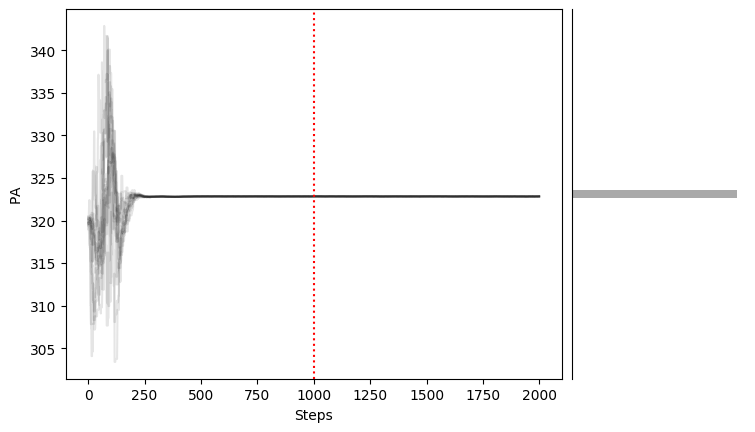

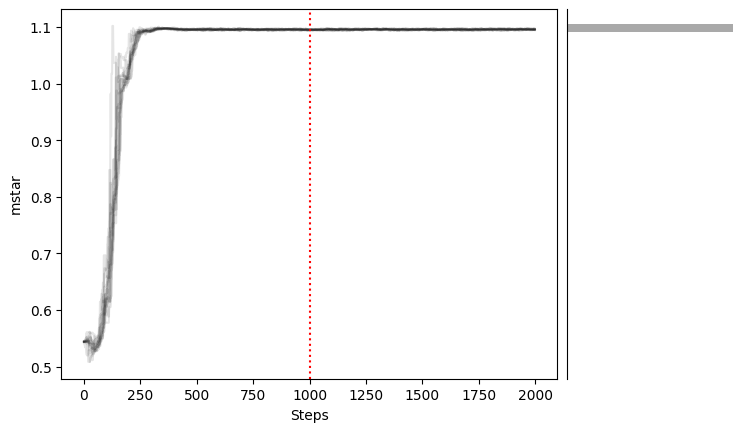

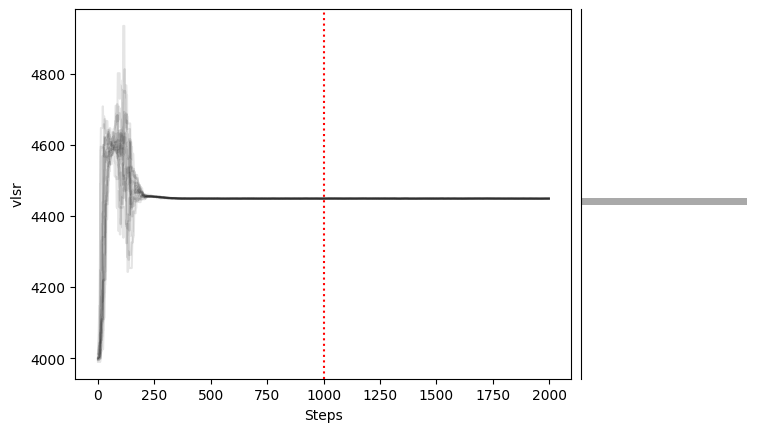

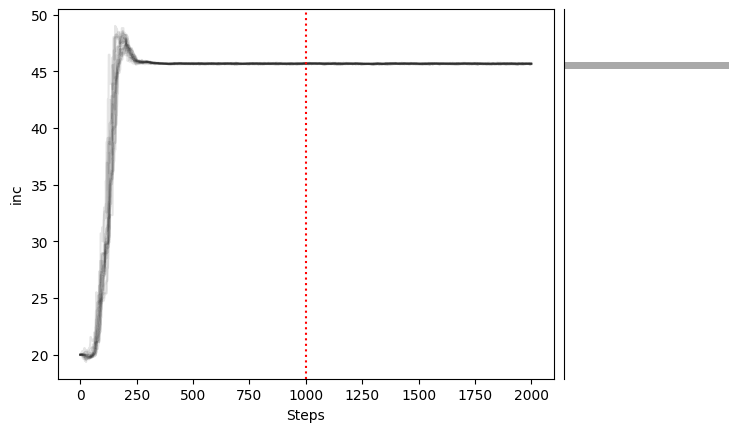

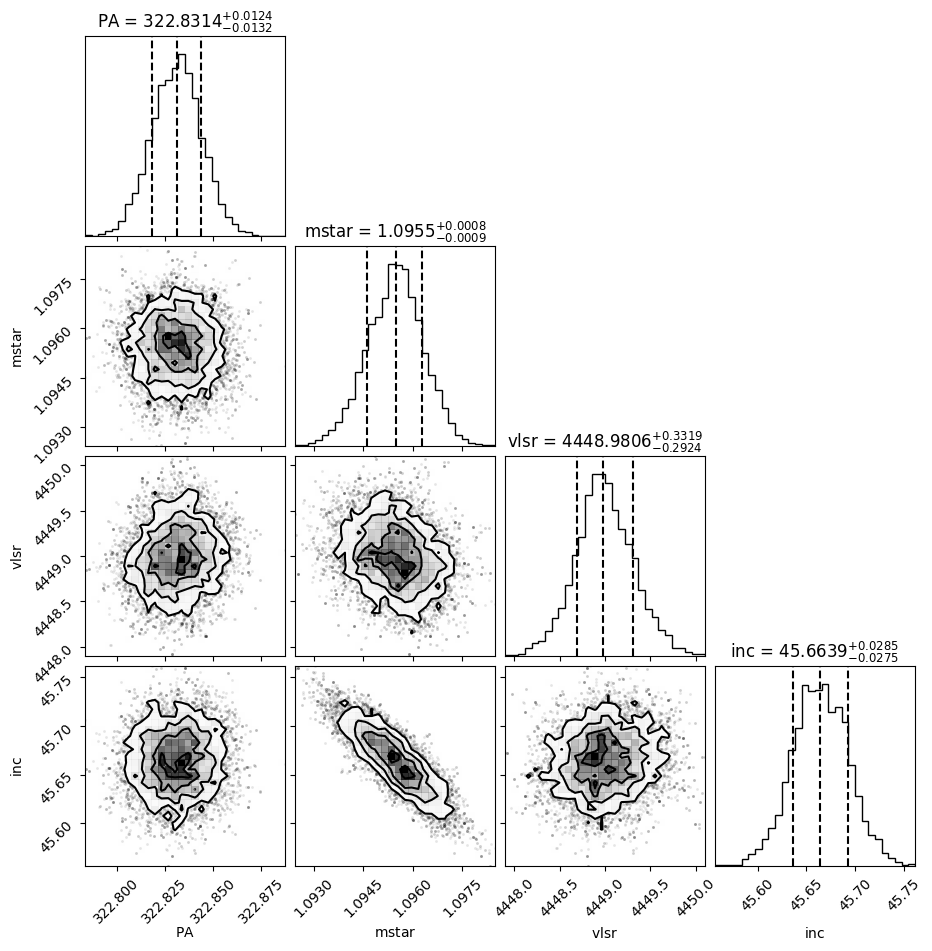

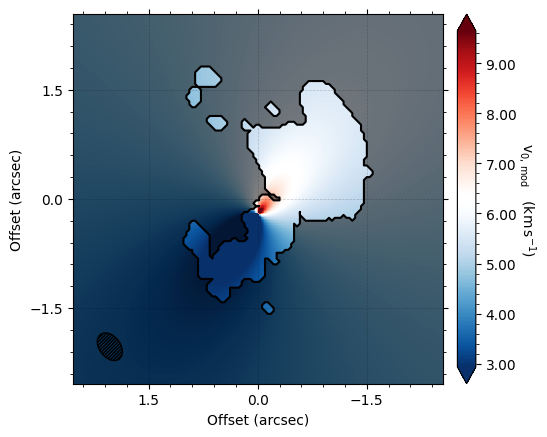

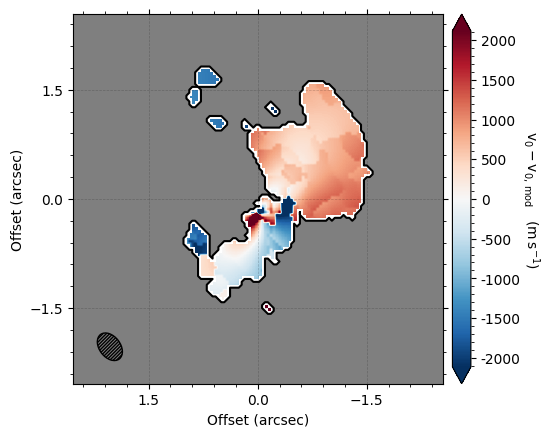

In [1092]:
nsims = 1000
nwalkers = 15

samples = cube.fit_map(p0=p0, params=params,
                       nwalkers=nwalkers, nburnin=1000, nsteps=nsims)

In [1094]:
# x_offset = np.median([x[0] for x in samples])
# y_offset = np.median([x[1] for x in samples])


PA = np.median([x[0] for x in samples])
M_star = np.median([x[1] for x in samples])
vlsr = np.median([x[2] for x in samples])

try:
    inc = np.median([x[3] for x in samples])
except:
    inc = params['inc']


PA_err_plus, PA_err_minus = np.percentile([x[0] for x in samples],84), np.percentile([x[0] for x in samples],16)

print(x_offset, ',', y_offset,',', PA, ',',(PA_err_plus-PA, PA-PA_err_minus),",",inc,',',(m1,m2,m3,m4))

322.83143469658614 , 1.0954854651279098 , 322.83143469658614 , (0.012393039886660517, 0.013244765532760994) , 45.66386960690285 , (0, 85, 120, 150)


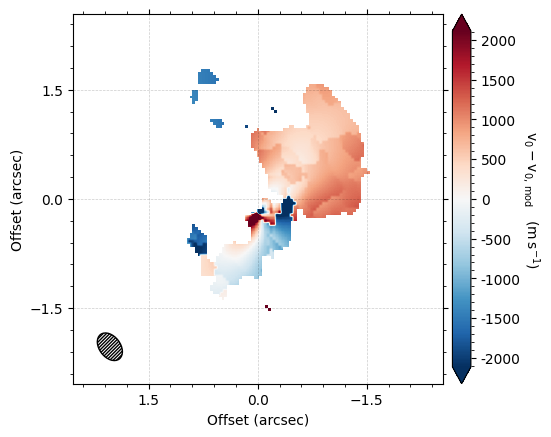

In [1095]:
model = cube.evaluate_models(samples=samples, params=params)

resid_fig = cube.plot_model_residual(model=model, return_fig=True, imshow_kwargs = {'vmin':})

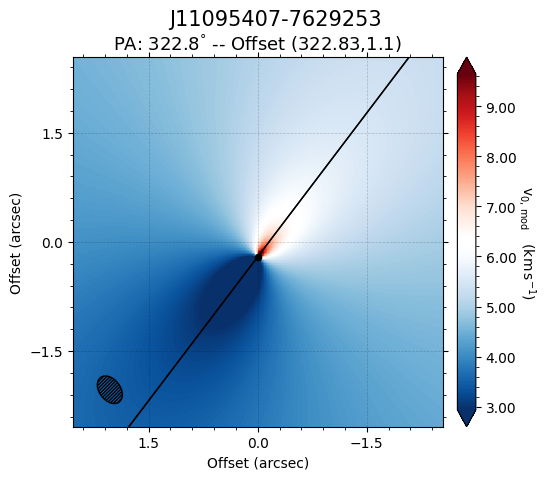

In [1096]:
model = cube.evaluate_models(samples=samples, params=params)
model_fig = cube.plot_model(model=model, return_fig = True,imshow_kwargs = {'vmin': 1.5})


axes_list = model_fig.axes

PA_slope = np.tan((PA+90)*np.pi / 180)
PA_slope_plus = np.tan((PA_err_plus+90)*np.pi / 180)
PA_slope_minus = np.tan((PA_err_minus+90)*np.pi / 180)


x= np.arange(-5,5,.1)
PA_line = -x * PA_slope
PA_line_plus = -x * PA_slope_plus
PA_line_min = -x * PA_slope_minus

axes_list[0].scatter(ra_diff_arcsecond, dec_diff_arcsecond, color='black',s=20)

axes_list[0].plot(x+ra_diff_arcsecond,PA_line_plus+dec_diff_arcsecond,color='black',linewidth=1)
axes_list[0].plot(x+ra_diff_arcsecond,PA_line_min+dec_diff_arcsecond,color='black',linewidth=1)


model_fig.suptitle(f"{infile.split('/')[-1].split('_')[0]}",fontsize=15)
axes_list[0].set_title(f"PA: {np.round(PA,1)}$^\degree$"+f" -- Offset ({np.round(x_offset,2)},{np.round(y_offset,2)})", fontsize=13,pad=5)
axes_list[0].scatter(x_offset,y_offset,s=50,color='black')
name = infile.split('/')[-1].split('_')[0] if infile.split('/')[-1].split('_')[1] != 'Tau' else '_'.join(infile.split('/')[-1].split('_')[:2])


# plt.savefig(f'/Users/calebpainter/Downloads/DECO/disk_plots_v/{name}.png')

In [1099]:
params.keys()

dict_keys(['x0', 'y0', 'PA', 'mstar', 'vlsr', 'inc', 'dist'])

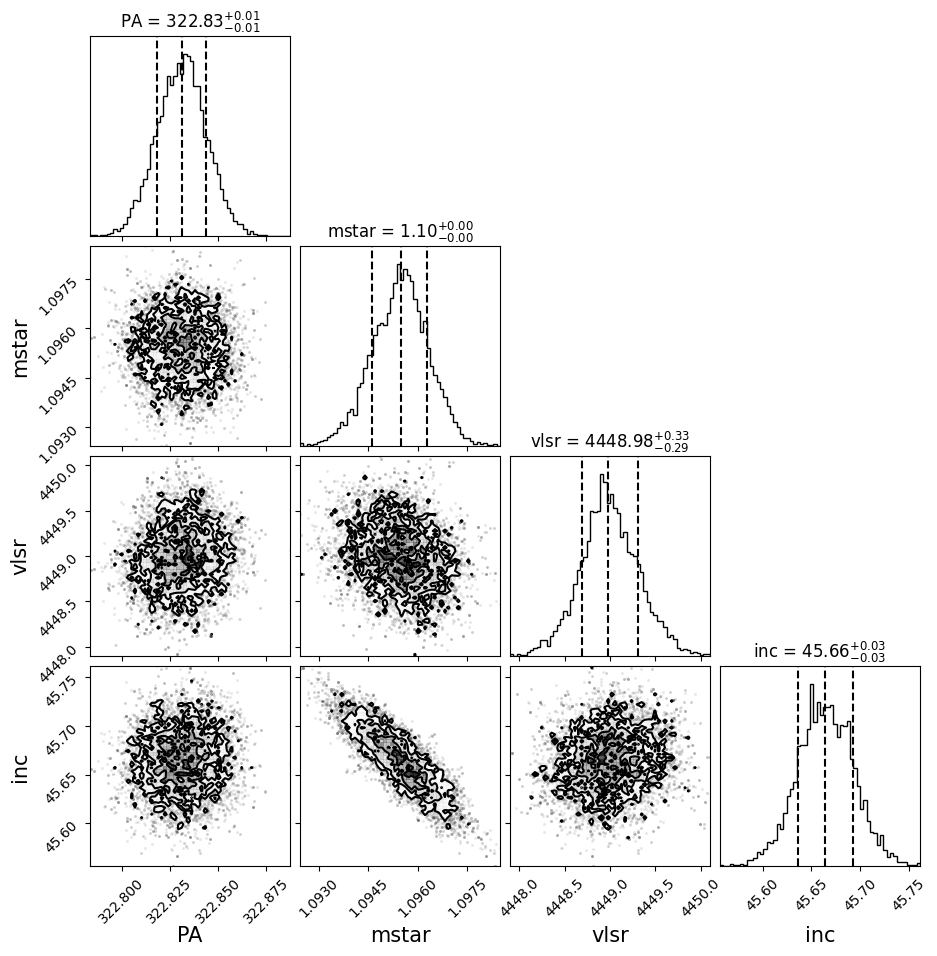

In [1101]:
corner_fig = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], labels=[l for l in list(params.keys())[2:6]], label_kwargs={"fontsize": 15}, show_titles=True, bins= 60)
rot_axes_list[0].plot(x+x_offset,PA_line_plus+y_offset,color='black',linewidth=1)
rot_axes_list[0].plot(x+x_offset,PA_line_min+y_offset,color='black',linewidth=1)


figs = [model_fig, rot_fig,resid_fig,corner_fig] # list of figures
with PdfPages(f'/Users/calebpainter/Downloads/Deco/code/disk_plots_v/full_diagnostic_{name}_{nsims}_sim_{nwalkers}_walkers.pdf') as pdf:
    for fig in figs:
        pdf.savefig(fig, bbox_inches='tight') 

In [1102]:
df.to_latex(index=False)

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

## Continuum Inclination

In [40]:
file_dir = '/Users/calebpainter/Downloads/products/new'
file_dirs = os.listdir(file_dir)
all_cont_files = []
for fdir in file_dirs:
    try:
        new_dir = file_dir+'/'+fdir+'/cont_images/'
        region_files = os.listdir(new_dir)
        all_cont_files.append(region_files)
    except:
        pass

In [46]:
CW

'J10590108-7722407'

In [60]:

file_dir = '/Users/calebpainter/Downloads/products/new'
file_dirs = os.listdir(file_dir)
all_cont_files = []
for fdir in file_dirs:
    try:
        new_dir = file_dir+'/'+fdir+'/cont_images/'
        region_files = os.listdir(new_dir)
        all_cont_files.append([new_dir + x for x in region_files])
    except:
        pass

disk_cont_file = None

for sublist in all_cont_files:
    for item in sublist:
        if name in item:
            disk_cont_file = item


In [61]:
all_cont_files

[['/Users/calebpainter/Downloads/products/new/Taurus_CCH_setting/cont_images/member.uid___A001_X2d20_X1f3d.CW_Tau_sci.spw25_27_29_31_33_35_37_39_41_43.cont.I.pbcor.fits',
  '/Users/calebpainter/Downloads/products/new/Taurus_CCH_setting/cont_images/member.uid___A001_X2d20_X1f3d.DL_Tau_sci.spw25_27_29_31_33_35_37_39_41_43.cont.I.pbcor.fits',
  '/Users/calebpainter/Downloads/products/new/Taurus_CCH_setting/cont_images/member.uid___A001_X2d20_X1f3d.DG_Tau_sci.spw25_27_29_31_33_35_37_39_41_43.cont.I.pbcor.fits',
  '/Users/calebpainter/Downloads/products/new/Taurus_CCH_setting/cont_images/member.uid___A001_X2d20_X1f3a.DS_Tau_sci.spw25_27_29_31_33_35_37_39_41_43.cont.I.pbcor.fits',
  '/Users/calebpainter/Downloads/products/new/Taurus_CCH_setting/cont_images/member.uid___A001_X2d20_X1f3d.GK_Tau_sci.spw25_27_29_31_33_35_37_39_41_43.cont.I.pbcor.fits',
  '/Users/calebpainter/Downloads/products/new/Taurus_CCH_setting/cont_images/member.uid___A001_X2d20_X1f3d.HO_Tau_sci.spw25_27_29_31_33_35_37_39_

/Users/calebpainter/Downloads/fits_downloads/J162713.7-241817_C18O_219.56GHz.image.fits


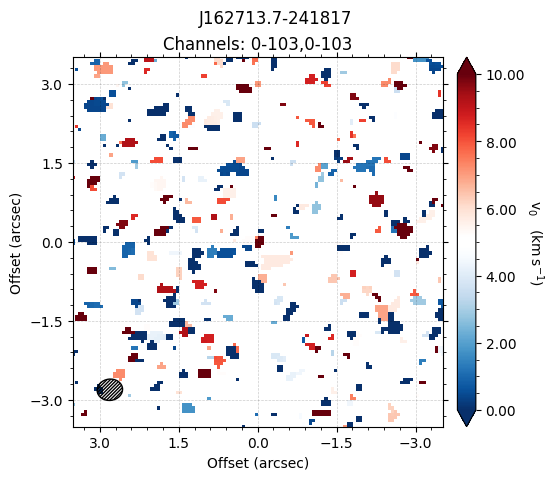

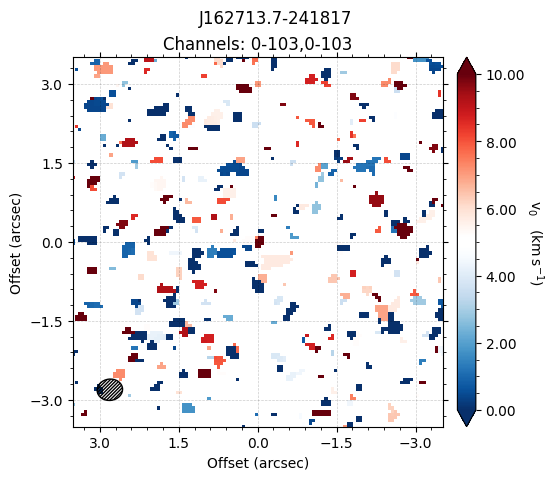

In [1012]:
file_number = 20
file_path = file_dir + file_paths[file_number]
print(file_path)

create_velocity_map(file_path,('full',0),3)


In [304]:
center_ra = disk_dict['ChamI'][name]['RA']
center_dec = disk_dict['ChamI'][name]['Dec']

# print(center_ra, center_dec)
print(Angle(center_ra * u.degree).hms,Angle(center_dec * u.degree).dms)

test_ra, test_dec = Angle('10:59:01.2301819678 hours').degree, Angle('-77:22:41.6674516505 degrees').degree
test_ra, test_dec

hms_tuple(h=10.0, m=59.0, s=0.9187000000009959) dms_tuple(d=-77.0, m=-22.0, s=-40.91459999996687)


(164.75512575819914, -77.37824095879179)